<a href="https://colab.research.google.com/github/RileyWClarke/fftpca_note/blob/master/FFTPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FFTPCA

In [254]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
import sklearn
from sklearn.preprocessing import scale

In [255]:
#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

In [256]:
#from google.colab import drive
#drive.mount("/content/gdrive")

## Reading in Data

### Short Cadence Data

In [257]:
# read data

data1=np.loadtxt('Data/phot211046195r2_ssc.2m0335.dat')
data2=np.loadtxt('Data/phot210327027r2_ssc.2m0355.dat')

time1,flux1,xx1,yy1=data1[:,0],data1[:,1],data1[:,2],data1[:,3]
time2,flux2,xx1,yy2=data2[:,0],data2[:,1],data2[:,2],data2[:,3]

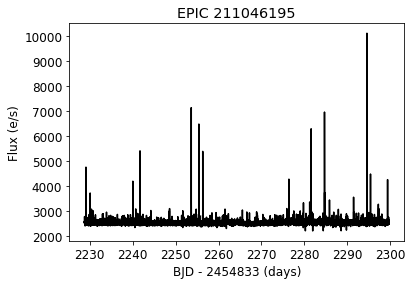

In [258]:
plt.plot(time1,flux1, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('Figures/toi1.png', dpi=100, bbox_inches='tight')

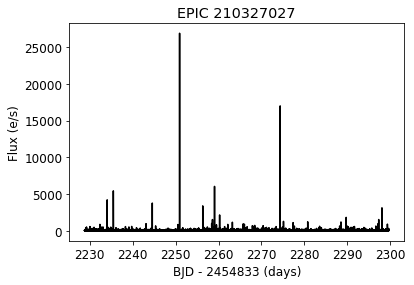

In [259]:
plt.plot(time2,flux2, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 210327027')
plt.savefig('Figures/toi2.png', dpi=100, bbox_inches='tight')

### Long Cadence Data

In [260]:
bjds = np.load('Data/bjds.npy')
fluxes = np.load('Data/fluxes.npy')
fluxerrs = np.load('Data/fluxerrs.npy')

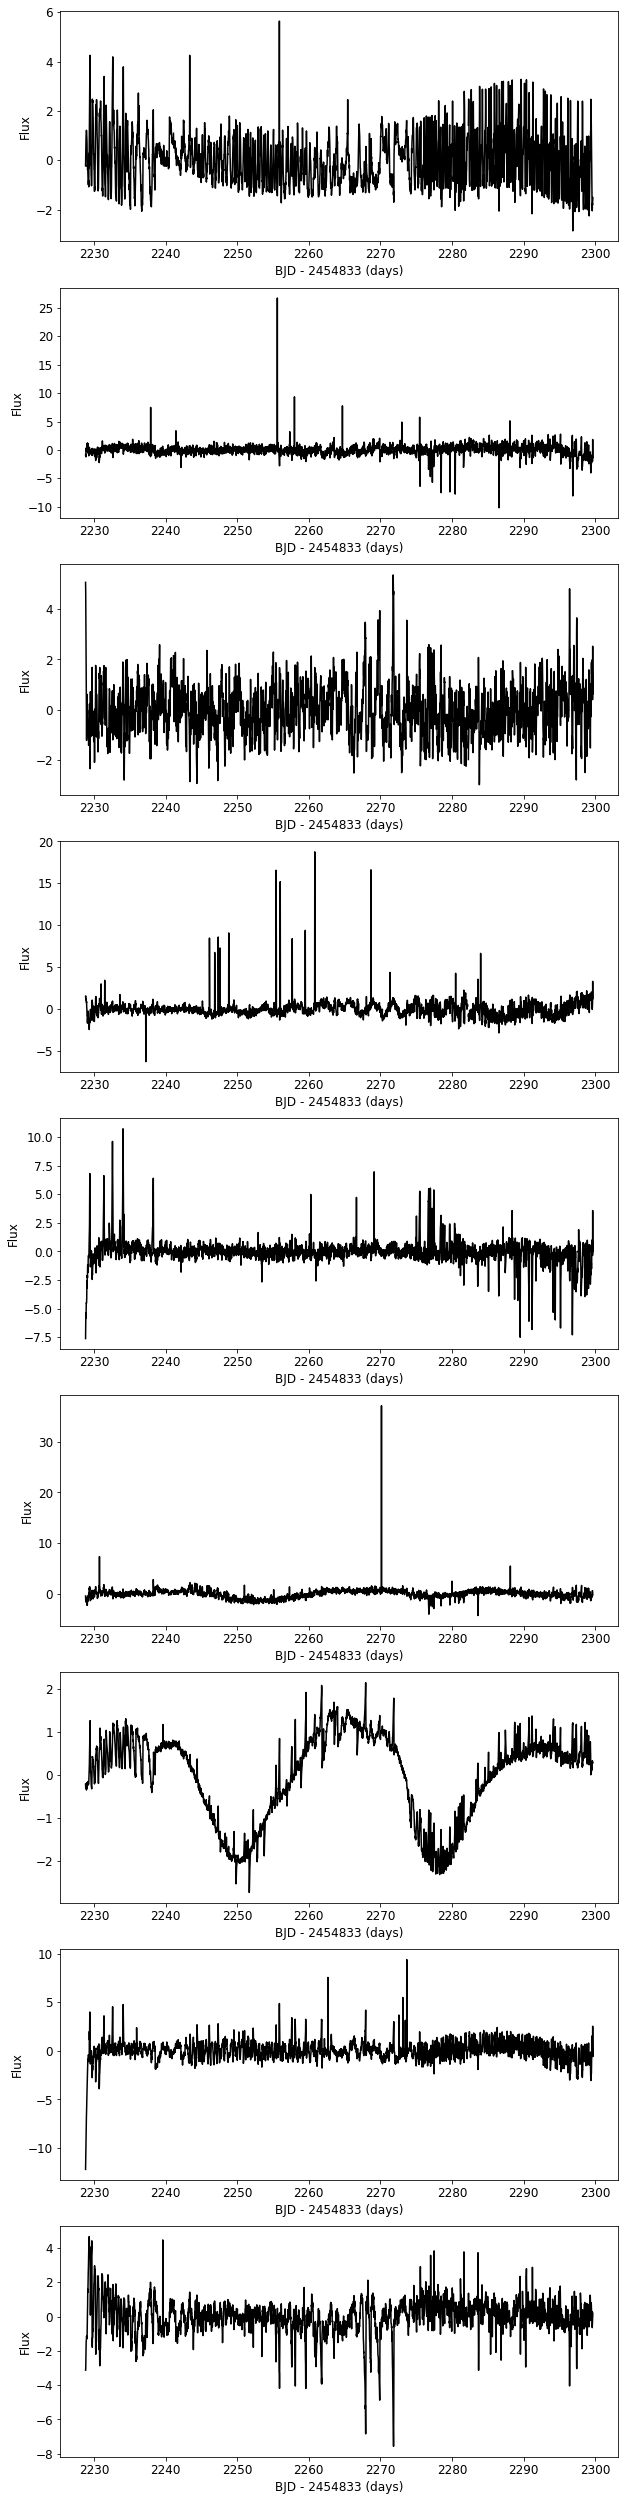

In [261]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1

# FFT Filtering

In [262]:
def invgaussian(a ,m, s, x):
    g = -a * np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [263]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, 
                  M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=''):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      #plt.xlim(0,100)
      #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()

    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      #plt.plot(freq[between], spectrum[between], alpha=0.5)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      #plt.xlim(0,100)
      #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()
    
    
    
    if Filter == 'box':
    
      #filtered_spectrum = spectrum.copy()
    
      if inv_box == True:
        x_1 = np.arange(0, Low_cutoff, 0.1)
        x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
        plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[lc] = 0.
        filtered_spectrum[hc] = 0.
      else:
        x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
      ig = invgaussian(1, np.median([low_cutoff,high_cutoff]), gf_sig, freq)
      filtered_spectrum = spectrum * ig
      if ('filter' in Plot) or ('All' in Plot):
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()

    if ('spec_filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.xlim(0,100)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()

    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal

    if ('signal_filtered' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10)) 
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
      #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, freq, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [264]:
dfts = []
pspectra = []
for i, flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

## Short Cadence FFT Filtering

In [265]:
flux1norm = flux1 / sigma_clip(flux1, sigma=3).mean()

In [266]:
flux2norm = flux2 / sigma_clip(flux2, sigma=3).mean()

In [267]:
Low_cutoff, High_cutoff, F_sample = 4.0, 4.2, np.diff(time1)[0]
Spectrum1, frequency1, Filtered_spectrum1, Filtered_signal1, Low_freq, High_freq = bandpass_ifft(time1, flux1norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.1, Filter='Gaussian')

In [268]:
Low_cutoff, High_cutoff, F_sample = 4.0, 4.2, np.diff(time2)[0]
Spectrum2, frequency2, Filtered_spectrum2, Filtered_signal2, Low_freq, High_freq = bandpass_ifft(time2, flux2norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.1, Filter='Gaussian')

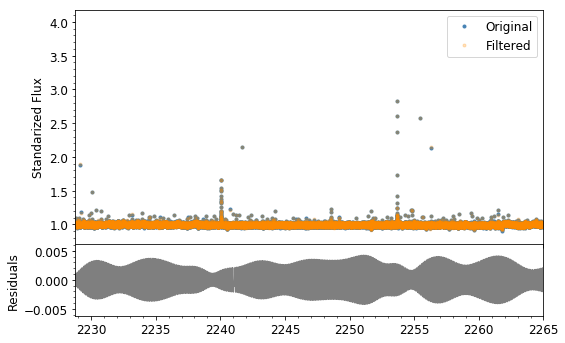

In [269]:
  fig = plt.figure(figsize=(10,5))

  res = flux1norm - Filtered_signal1

  left, width = 0.1, 0.65
  bottom, height = 0.1, 0.65

  rect_scatter = [left, bottom + 0.2, width, height]
  rect_histx = [left, bottom, width, 0.2]
  plt.subplots_adjust(hspace=0., wspace=0.1)
  ax1 = plt.axes(rect_scatter)
  axres = plt.axes(rect_histx)
  ax1.minorticks_on()
  axres.minorticks_on()
  plt.setp(ax1.get_xticklabels(),
            visible=False)

  ax1.errorbar(time1, flux1norm, color='SteelBlue', alpha=1,
                                 marker='.', fmt='.', label='Original')
  ax1.errorbar(time1, Filtered_signal1,
                                 color='DarkOrange', alpha=0.25,
                                 marker='.', fmt='.', label='Filtered')
  ax1.set_ylabel('Standarized Flux')
  ax1.legend(fontsize=12)

  axres.plot(time1, res, color='k', alpha=0.5)
  axres.set_ylabel('Residuals')

  ax1.set_xlim(time1[0], 2265)
  #ax1.set_ylim(-2,2)
  axres.set_xlim(time1[0], 2265)
  #axres.set_ylim(-0.5,0.5)

plt.savefig('Figures/resids.png', dpi=100, bbox_inches='tight');

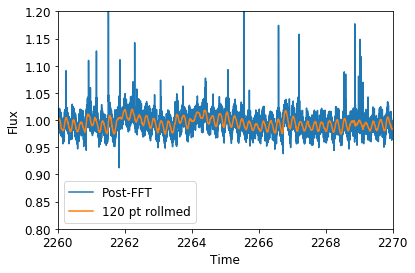

In [270]:
s = pd.Series(Filtered_signal1)
window=120
sroll = s.rolling(window, center=True).median()
plt.plot(time1, Filtered_signal1, label='Post-FFT')
plt.plot(time1, sroll.values, label='{} pt rollmed'.format(window))
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(2260,2270)
plt.ylim(0.8,1.2)
plt.legend();

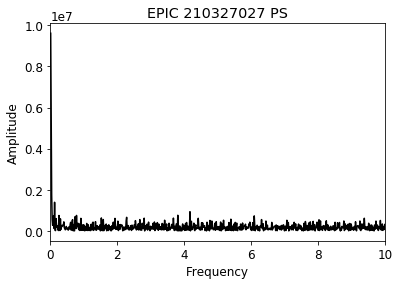

In [271]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 210327027 PS')
plt.xlim(0,10)
plt.savefig('Figures/toi2ps.png', dpi=100, bbox_inches='tight')

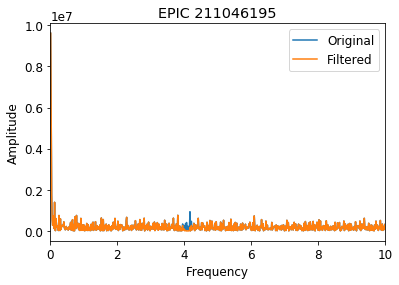

In [272]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, label='Original')
plt.plot(frequency2[1:],np.abs(Filtered_spectrum2[1:])**2, label='Filtered')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 211046195')
plt.legend(fontsize=12)
plt.xlim(0,10);

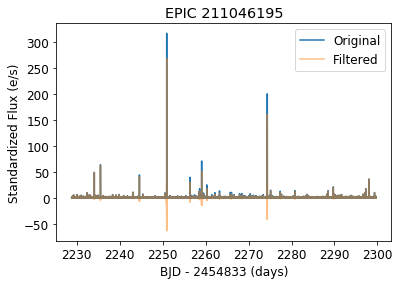

In [273]:
plt.plot(time2,flux2norm, label='Original')
plt.plot(time2[1:],Filtered_signal2,alpha=0.5, label='Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Standardized Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('Figures/toi2_filtered.png', dpi=100, bbox_inches='tight')
plt.legend(fontsize=12);

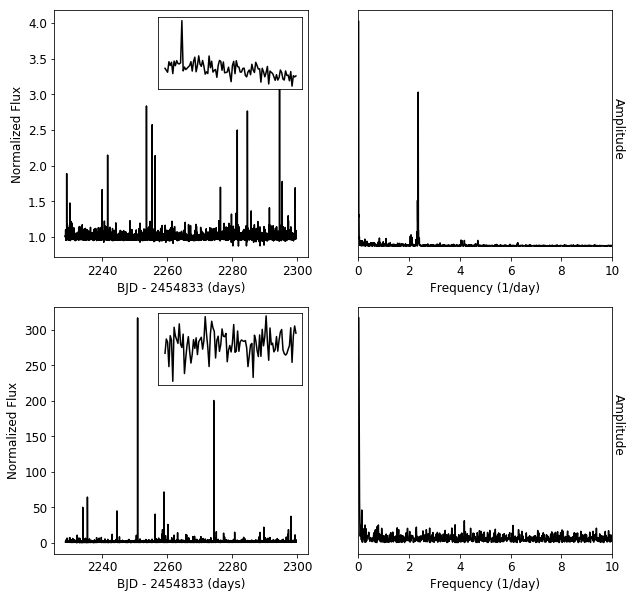

In [274]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(time1,flux1norm, c='k')
ax[1,0].plot(time2,flux2norm, c='k')
ax[0,1].plot(frequency1[1:],np.abs(Spectrum1[1:])**2, c='k')
ax[1,1].plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')

ax[0,0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[0,1].set_xlabel('Frequency (1/day)', fontsize = 12)
ax[1,0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[1,1].set_xlabel('Frequency (1/day)', fontsize = 12)

ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[1,0].set_ylabel('Normalized Flux', fontsize = 12)

ax[0,1].text(10, ax[0,1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)
ax[1,1].text(10, ax[1,1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)

ax[0,1].set_xlim(0,10)
ax[1,1].set_xlim(0,10)

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

#ax[0,0].vlines(time1[0],0.75,1.25, color='r')
#ax[0,0].vlines(time1[10000],0.75,1.25, color='r')
#ax[0,0].hlines(1.25, time1[0], time1[10000], color='r')
#ax[0,0].hlines(0.75, time1[0], time1[10000], color='r')

subax1 = plt.axes([0.27, 0.77, .2, .1])
subax1.plot(time1[0:100],flux1norm[0:100], color='k')
subax1.get_xaxis().set_ticks([])
subax1.get_yaxis().set_ticks([])

subax2 = plt.axes([0.27, 0.36, .2, .1])
subax2.plot(time2[0:100],flux2norm[0:100], color='k')
subax2.get_xaxis().set_ticks([])
subax2.get_yaxis().set_ticks([]);


plt.savefig('Figures/4plot.png', dpi=100, bbox_inches='tight')

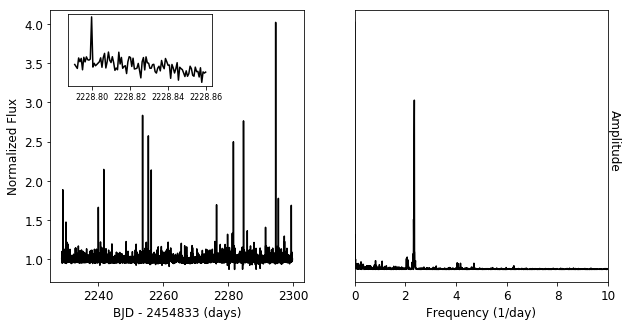

In [275]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(time1,flux1norm, c='k')
ax[1].plot(frequency1[1:],np.abs(Spectrum1[1:])**2, c='k')

ax[0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[1].set_xlabel('Frequency (1/day)', fontsize = 12)
ax[0].set_ylabel('Normalized Flux', fontsize = 12)

ax[1].text(10, ax[1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)

ax[1].set_xlim(0,10)

ax[1].set_yticks([])

subax1 = plt.axes([0.15, 0.67, .2, .2])
subax1.plot(time1[0:100],flux1norm[0:100], color='k')
subax1.get_yaxis().set_ticks([])
subax1.ticklabel_format(useOffset=False)
subax1.tick_params(axis='both', labelsize=8)

plt.savefig('Figures/2plot.png', dpi=100, bbox_inches='tight')

# PCA with Spectra

In [276]:
from sklearn.decomposition import PCA

In [277]:
pspec_dict = {}

for j, spec in enumerate(pspectra):
  pspec_dict["spec{0}".format(j)] = spec

pspec_df = pd.DataFrame(data=pspec_dict)

In [278]:
pspec_df.head()

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,...,spec990,spec991,spec992,spec993,spec994,spec995,spec996,spec997,spec998,spec999
0,2444.330836,3491.401379,17691.849961,24.533747,6.163901e+03,631.853491,276.295785,15020.322357,195.025521,22788.457538,...,33.260864,8.329918e+01,429.686300,3.495277e+02,10.796121,604.412834,74.000805,15.231185,1578.632726,0.325671
1,188558.097947,24932.464107,27502.736287,11596.062242,1.329584e+06,21881.098032,7824.408002,1708.935209,33900.530576,106001.638933,...,39012.940662,2.852149e+04,221522.421770,2.701112e+05,16677.137662,78130.343520,54050.845570,7015.700238,701.526990,33601.833088
2,137018.884662,40621.698347,26031.074624,99011.951142,1.027931e+05,60128.856707,74299.255923,12094.348022,523997.575650,84198.566845,...,1388.401516,7.674183e+04,411180.284071,1.482621e+05,86068.824882,164012.481497,86414.240316,6035.216574,83485.735451,23158.742652
3,8088.677230,1279.610214,25525.877039,7997.888711,1.717962e+05,15107.184941,41440.697136,7385.217256,68834.422406,119432.561355,...,1653.227609,1.331502e+05,370.357912,2.498437e+05,193504.408819,8440.866909,14802.618608,16771.383378,4520.744261,5862.505022
4,38741.302025,32673.694499,103469.748680,7106.695823,1.824596e+05,8008.003119,236357.760858,92934.117258,17320.909253,47588.485578,...,13031.507391,1.834104e+06,7710.168343,2.331563e+06,44564.275246,32945.930265,111682.212681,26327.696869,36660.220971,1539.411083


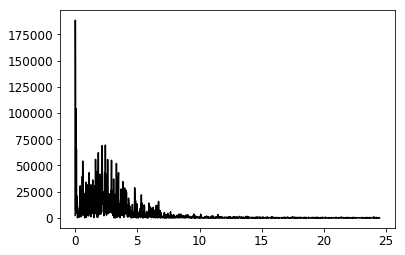

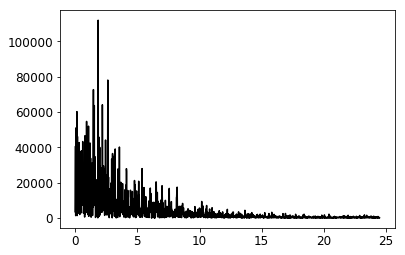

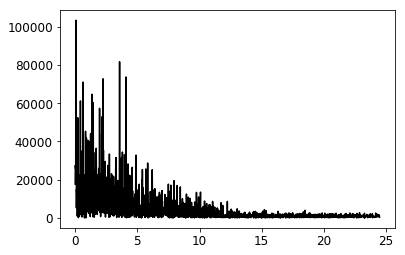

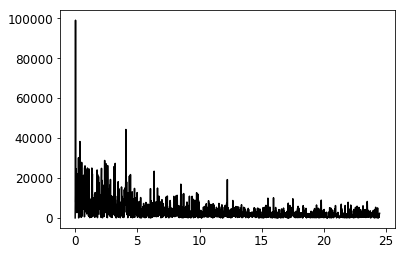

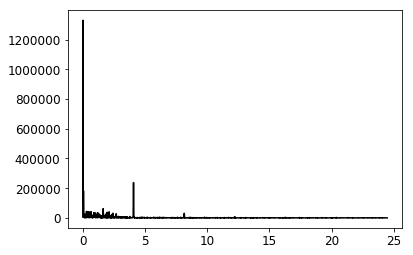

In [279]:
for i in range(5):
  plt.plot(frequency, pspec_df.values[:,i], c='k')
  plt.show()

In [280]:
'''
### Remove first values from PS:
pspec_df = pspec_df.drop([0,1,2,3,4])
pspec_df.head()
'''

'\n### Remove first values from PS:\npspec_df = pspec_df.drop([0,1,2,3,4])\npspec_df.head()\n'

In [281]:
pspec_df.shape

(1735, 1000)

In [282]:
x = pspec_df.values
x = scale(x, axis=0)

In [283]:
pca = PCA()

pca.fit(x)

X = pca.transform(x)

pca_df = pd.DataFrame(data = X)
print(pca_df.shape)
pca_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.976851,5.335109,-0.635924,0.426727,-0.149198,0.594171,1.446605,0.675921,0.419251,-0.170973,...,9.705129e-05,-1.991950e-05,1.209915e-05,1.607438e-05,-1.457954e-05,-5.352218e-06,-2.024611e-05,-1.570068e-05,-1.613461e-06,-2.141829e-07
1,204.148185,295.006662,-6.975532,40.328249,32.018923,-11.744238,-18.781720,-3.156247,-2.028993,1.815808,...,-7.305529e-08,1.089954e-08,-7.434678e-09,-1.106568e-08,2.230695e-08,5.975956e-09,2.087342e-08,1.388444e-08,2.734884e-09,-6.735569e-10
2,372.084336,-27.892496,241.148784,-66.463167,-26.688698,-5.604747,-7.383737,1.605789,-2.771667,-1.688595,...,3.325794e-08,-3.521616e-08,6.196570e-08,-4.798948e-08,1.852050e-08,-2.399049e-08,-1.306440e-08,-1.052070e-08,-1.940447e-08,2.089709e-08
3,267.782555,-62.642841,-25.544949,204.578245,-105.998911,-2.221424,-18.307529,2.020841,-3.571498,1.620010,...,-8.086415e-08,-9.126746e-08,3.000561e-08,6.304849e-08,-1.127478e-08,-1.099796e-10,-2.337176e-08,-2.024113e-08,2.418073e-08,-2.636521e-08
4,234.667100,-70.390801,-15.216099,53.341804,165.906755,108.825482,-10.195769,-12.742281,-1.464725,5.277979,...,4.346168e-08,-2.845333e-08,-1.768161e-08,3.585069e-08,-2.087025e-08,-1.040076e-08,1.059473e-08,-1.722237e-08,7.806284e-09,-1.508386e-09


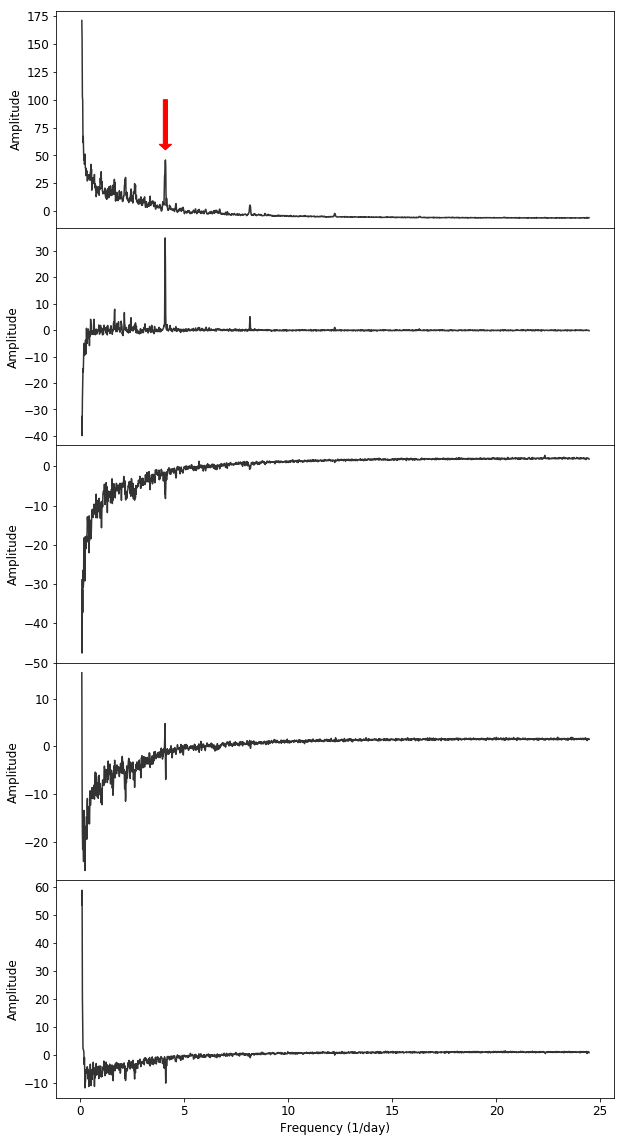

In [284]:
fig, axes = plt.subplots(5, figsize=(10,20), sharex=True)
p = 0
for i in range(5):
  axes[p].plot(frequency[5:],pca_df[i][5:], c='k', alpha=0.8)
  axes[p].set_ylabel('Amplitude')
  p += 1
axes[0].arrow(4.09, 100, 0, -40, width=0.2, head_length=5, color='red')
plt.xlabel('Frequency (1/day)')
plt.subplots_adjust(hspace=0)
plt.savefig('Figures/pspcs.png', dpi=100, bbox_inches='tight')

In [285]:
frequency[5:][np.where(pca_df[0][5:] == pca_df[0][75:].max())[0]]

array([4.0914055])

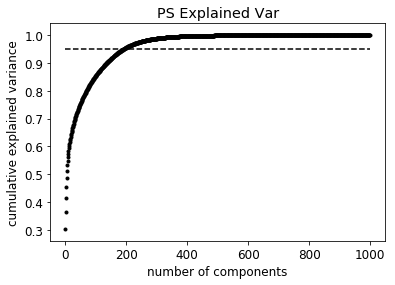

In [286]:
a = np.arange(0,len(x[0]))
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(x[0]),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PS Explained Var')
plt.savefig('Figures/expvar.png', bbox_inches='tight')

## Method 1: Removing First 2 Components entirely

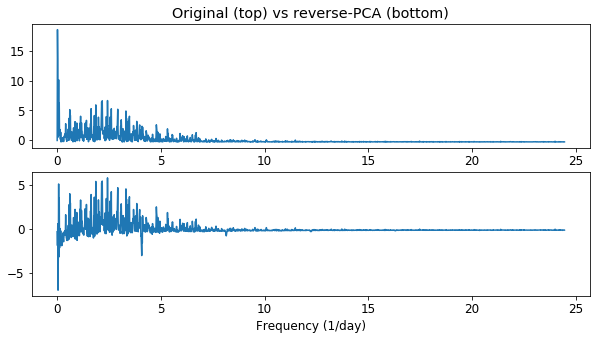

In [287]:
nComp = 200
Xhat = np.dot(pca.transform(x)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency, Xhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

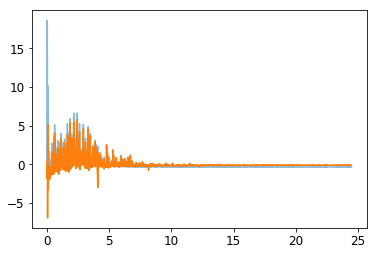

In [288]:
plt.plot(frequency,x[:,0], alpha=0.5)
plt.plot(frequency, Xhat[:,0]);

## Method 2: Bandpass Filtering First 2 Components

In [289]:
def gaussian(a, m, s, x):
    g = a * np.exp(-(m-x)**2 / s**2) 
    return g

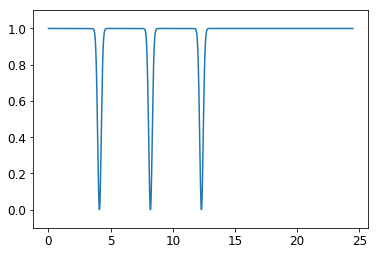

In [290]:
def hrm_gfilter(x, s, fund, nhrm=0, amps=np.ones(len(x))):

  fhrms = np.array([fund])

  for i in range(2, nhrm+2):
    fhrms = np.append(fhrms, i*fund)

  filt = np.ones(len(x))

  for hrm, amp in zip(fhrms, amps):
    filt *= invgaussian(amp,hrm,s,x) 
   # filt += gaussian(amp,hrm,s,x)

  return filt

filt = hrm_gfilter(frequency, 0.2, 4.1, 2)

plt.plot(frequency, filt)
plt.ylim(-0.1,1.1);

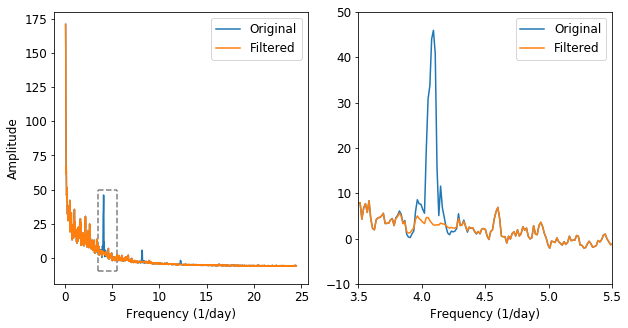

In [291]:
###Bandpass filtering:

#Some params:
fstep = np.diff(frequency).mean()
fund = 4.1
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)

pc1 = np.copy(pca_df[0])#to avoid overwriting

#Make array of fund & harmonic indices:
hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


#For each index, calculate local avg, subtract, filter, add avg back:
for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((pc1[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       pc1[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  pc1[5:] -= local_avg
  pc1[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  pc1[5:] += local_avg

#Plotting:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca_df[0][5:], label='Original')
ax[0].plot(frequency[5:], pc1[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca_df[0][5:], label='Original')
ax[1].plot(frequency[5:], pc1[5:], label='Filtered')
ax[0].set_xlabel('Frequency (1/day)')
ax[1].set_xlabel('Frequency (1/day)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

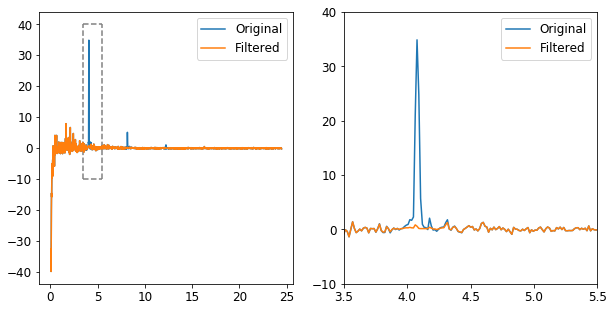

In [292]:
fstep = np.diff(frequency).mean()
fund = 4.1
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
pc2 = np.copy(pca_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((pc2[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       pc2[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  pc2[5:] -= local_avg
  pc2[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  pc2[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca_df[1][5:], label='Original')
ax[0].plot(frequency[5:], pc2[5:], label='Filtered')
ax[0].vlines(3.5,-10,40, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,40, color='grey', linestyle='--')
ax[0].hlines(40,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca_df[1][5:], label='Original')
ax[1].plot(frequency[5:], pc2[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,40)
ax[0].legend()
ax[1].legend();

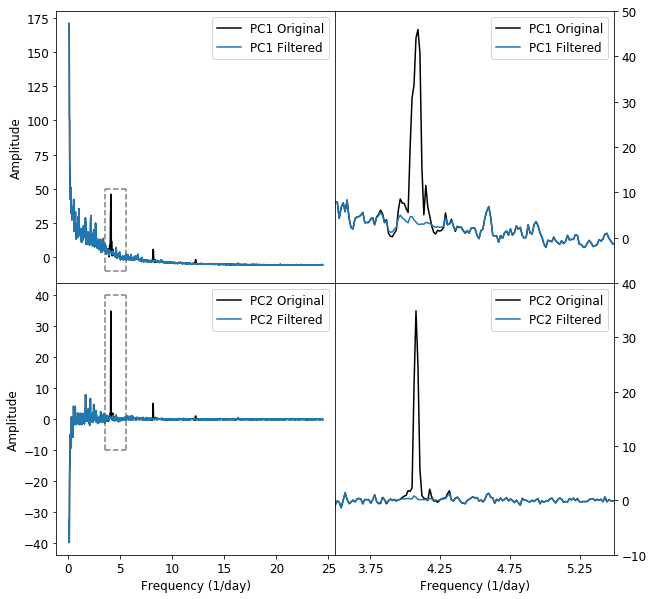

In [293]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
plt.subplots_adjust(wspace=0,hspace=0)

ax[0,0].plot(frequency[5:], pca_df[0][5:], c='k', label='PC1 Original')
ax[0,0].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
ax[0,0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0,0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0,0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0,0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[0,0].set_xlabel('Frequency (1/day)')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].legend()

ax[0,1].plot(frequency[5:], pca_df[0][5:], c='k', label='PC1 Original')
ax[0,1].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
ax[0,1].set_xlabel('Frequency (1/day)')
ax[0,1].set_xlim(3.5,5.5)
ax[0,1].set_ylim(-10,50)
ax[0,1].set_xticks([])
ax[0,1].set_yticks(np.arange(0,60,10))
ax[0,1].yaxis.tick_right()
ax[0,1].legend()

ax[1,0].plot(frequency[5:], pca_df[1][5:], c='k', label='PC2 Original')
ax[1,0].plot(frequency[5:], pc2[5:], label='PC2 Filtered')
ax[1,0].vlines(3.5,-10,40, color='grey', linestyle='--')
ax[1,0].vlines(5.5,-10,40, color='grey', linestyle='--')
ax[1,0].hlines(40,3.5,5.5, color='grey', linestyle='--')
ax[1,0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1,0].set_xlabel('Frequency (1/day)')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].legend()

ax[1,1].plot(frequency[5:], pca_df[1][5:], c='k', label='PC2 Original')
ax[1,1].plot(frequency[5:], pc2[5:], label='PC2 Filtered')
ax[1,1].set_xlabel('Frequency (1/day)')
ax[1,1].set_xlim(3.5,5.5)
ax[1,1].set_ylim(-10,40)
ax[1,1].yaxis.tick_right()
ax[1,1].set_xticks(np.arange(3.75,5.5,.5))
ax[1,1].legend()

plt.savefig('Figures/pcfilter.png', dpi=100, bbox_inches='tight');

In [294]:
t = np.array([pc1,pc2])
filtered_transform = pca.transform(x).copy()
print(t.T.shape, filtered_transform[:,0:2].shape)
filtered_transform[:,0:2] = t.T

(1735, 2) (1735, 2)


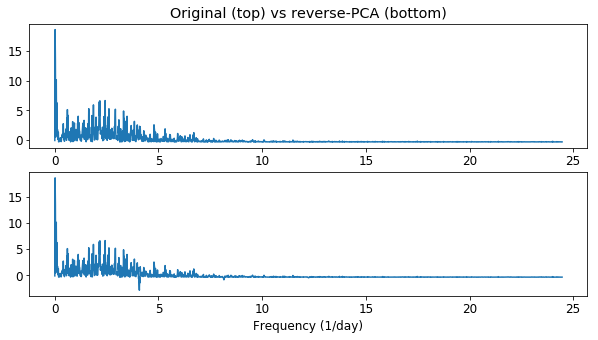

In [295]:
Xhat1 = np.dot(filtered_transform[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency,Xhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

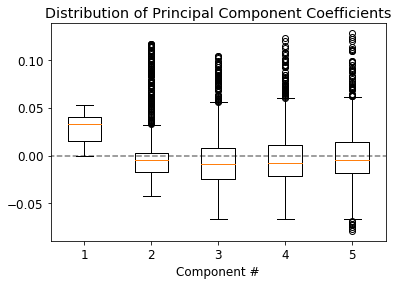

In [296]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.hlines(0, 0, 7, linestyle='--', alpha=0.5)
plt.xlabel('Component #')
plt.title('Distribution of Principal Component Coefficients')
plt.xlim(0.5,5.5)
plt.savefig('Figures/box.png', dpi=100, bbox_inches='tight')
plt.show()

In [297]:
d = {'pc1':pca.components_[0],'pc2':pca.components_[1],'pc3':pca.components_[2],'pc4':pca.components_[3],'pc5':pca.components_[4]}
coeff_df = pd.DataFrame(data=d)
coeff_df.to_csv('Data/coeffs.csv')

In [298]:
np.where(pca.components_[0] == pca.components_[0].max())[0]

array([630])

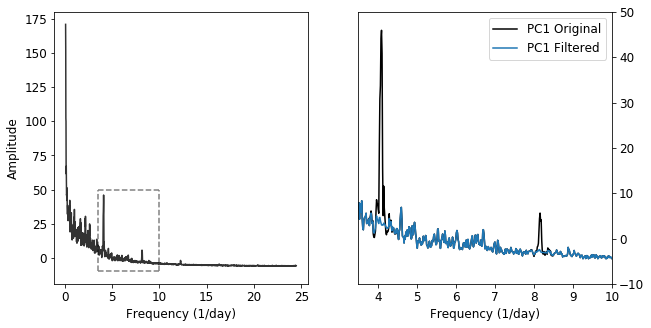

In [299]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(frequency[5:],pca_df[0][5:], c='k', alpha=0.8)
axes[0].set_ylabel('Amplitude')
axes[0].vlines(3.5,-10,50, color='grey', linestyle='--')
axes[0].vlines(10,-10,50, color='grey', linestyle='--')
axes[0].hlines(50,3.5,10, color='grey', linestyle='--')
axes[0].hlines(-10,3.5,10, color='grey', linestyle='--')
axes[0].set_xlabel('Frequency (1/day)')
#ax2.set_xticks([])
#ax2.set_xticklabels([])

axes[1].plot(frequency[5:], pca_df[0][5:], c='k',label='PC1 Original')
axes[1].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
axes[1].set_xlim(3.5,10)
axes[1].set_ylim(-10,50)
#axes[1].set_xticks([])
#axes[1].set_xticklabels([])
axes[1].yaxis.tick_right()
axes[1].set_xlabel('Frequency (1/day)')
axes[1].legend()

plt.savefig('Figures/pc1_filtered.png',dpi=300, bbox_inches='tight')

# PCA with DFTs

In [300]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

In [301]:
y = dft_df.values
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

In [302]:
print(y[:,0].real.mean(), y[:,0].imag.mean())

2.047673590086744e-18 8.190694360346977e-18


In [303]:
print(y[:,0].real.std(), y[:,0].imag.std())

1.0 1.0


In [304]:
pca2 = PCA()

pca2.fit(y.real)

Y = pca2.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)


pca2i = PCA()

pca2i.fit(y.imag)

Yi = pca2i.transform(y.imag)

pca2i_df = pd.DataFrame(data = Yi)
print(pca2i_df.shape)

(1735, 1000)
(1735, 1000)


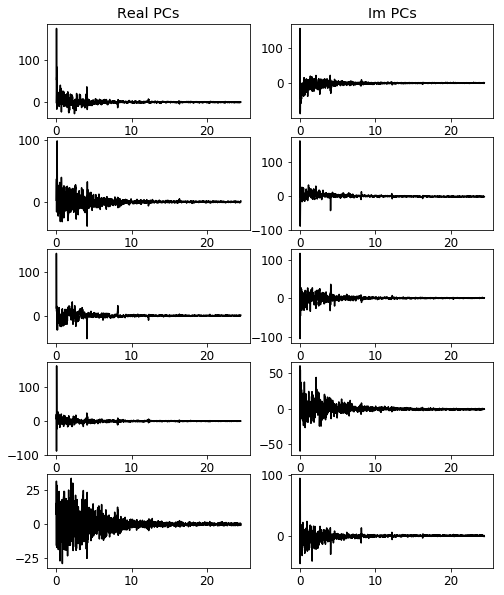

In [305]:
fig, axes = plt.subplots(5,2, figsize=(8,10))

for i in range(0,5):
  axes[i,0].plot(frequency,pca2_df[i], 'k')
  axes[i,1].plot(frequency,pca2i_df[i], 'k')
  axes[0,0].set_title('Real PCs')
  axes[0,1].set_title('Im PCs')


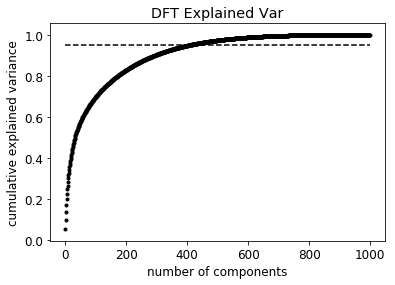

In [306]:
a = np.arange(len(y[0]))
plt.scatter(a, np.cumsum(pca2.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(a),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('DFT Explained Var')
plt.savefig('Figures/expvar2.png', bbox_inches='tight')

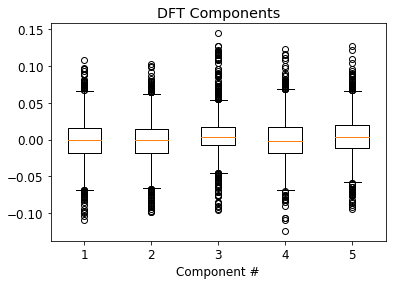

In [307]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca2.components_[0], pca2.components_[1], pca2.components_[2], pca2.components_[3],pca2.components_[4]])
plt.xlabel('Component #')
plt.title('DFT Components')
plt.savefig('Figures/box2.png', dpi=100, bbox_inches='tight')
plt.show()

## Removing 1st Component

In [308]:
'''
nComp = 400
Yhat = np.dot(pca2.transform(y.real)[:,2:nComp], pca2.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')
'''

"\nnComp = 400\nYhat = np.dot(pca2.transform(y.real)[:,2:nComp], pca2.components_[2:nComp,:])\n\nfig, axes = plt.subplots(2,1,figsize = (10,5))\naxes[0].plot(frequency,y[:,0])\naxes[1].plot(frequency, Yhat[:,0])\n#axes[0].set_ylim(-4,6)\n#axes[1].set_ylim(-4,6)\n\n\naxes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')\nplt.xlabel('Frequency (1/day)')\nplt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')\n"

In [309]:
'''
plt.plot(frequency,y[:,0])
plt.plot(frequency, Yhat[:,0],alpha=0.5)
plt.xlabel('Frequency (1/day)');
'''

"\nplt.plot(frequency,y[:,0])\nplt.plot(frequency, Yhat[:,0],alpha=0.5)\nplt.xlabel('Frequency (1/day)');\n"

In [310]:
'''
Yhatc = Yhat + (1j)*y.imag
'''

'\nYhatc = Yhat + (1j)*y.imag\n'

In [311]:
'''
for i in range(0,900,100):
  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i][1:],np.fft.irfft(Yhatc[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  plt.show()
  '''

"\nfor i in range(0,900,100):\n  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')\n  plt.plot(bjds[i][1:],np.fft.irfft(Yhatc[:,i]), alpha=0.5, label='PCA-Filtered')\n  plt.xlabel('BJD - 2454833 (days)')\n  plt.ylabel('Standardized Flux')\n  plt.legend(fontsize=12)\n  plt.show()\n  "

## Bandpass Filtering 1st Component

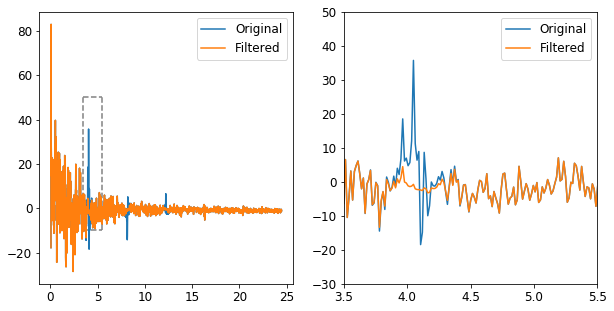

In [312]:
### BANDPASS FILTERING PC1 & PC2
#PC1 - real part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc1 = np.copy(pca2_df[0])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc1[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc1[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc1[5:] -= local_avg
  dftpc1[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc1[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2_df[0][5:], label='Original')
ax[0].plot(frequency[5:], dftpc1[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2_df[0][5:], label='Original')
ax[1].plot(frequency[5:], dftpc1[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-30,50)
ax[0].legend()
ax[1].legend();

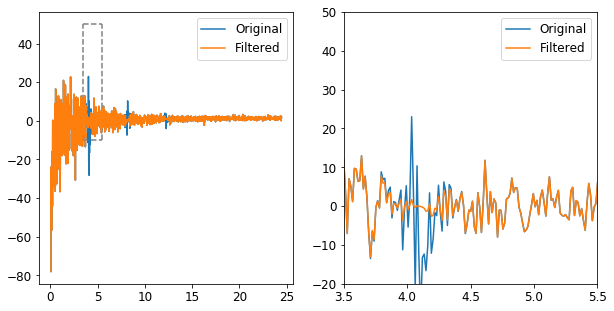

In [313]:
#PC1 - Im part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc1i = np.copy(pca2i_df[0])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc1i[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc1i[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc1i[5:] -= local_avg
  dftpc1i[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc1i[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2i_df[0][5:], label='Original')
ax[0].plot(frequency[5:], dftpc1i[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2i_df[0][5:], label='Original')
ax[1].plot(frequency[5:], dftpc1i[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-20,50)
ax[0].legend()
ax[1].legend();

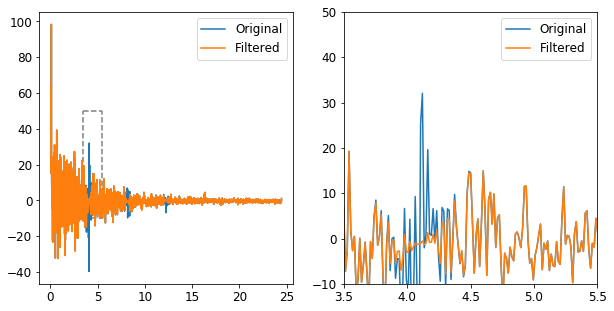

In [314]:
#PC2 - real part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc2 = np.copy(pca2_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc2[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc2[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc2[5:] -= local_avg
  dftpc2[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc2[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2_df[1][5:], label='Original')
ax[0].plot(frequency[5:], dftpc2[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2_df[1][5:], label='Original')
ax[1].plot(frequency[5:], dftpc2[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

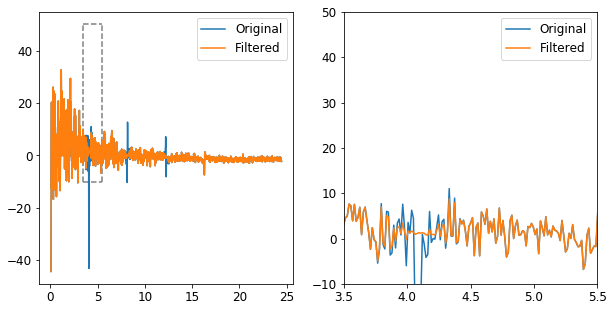

In [315]:
#PC2 - im part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc2i = np.copy(pca2i_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc2i[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc2i[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc2i[5:] -= local_avg
  dftpc2i[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc2i[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2i_df[1][5:], label='Original')
ax[0].plot(frequency[5:], dftpc2i[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2i_df[1][5:], label='Original')
ax[1].plot(frequency[5:], dftpc2i[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

In [316]:
#Replace first two PCs with filtered versions

t = np.array([dftpc1, dftpc2])
ti = np.array([dftpc1i, dftpc2i])

filtered_transform2 = pca2.transform(y.real).copy()
filtered_transform2i = pca2i.transform(y.imag).copy()

filtered_transform2[:,0:2] = t.T
filtered_transform2i[:,0:2] = ti.T

In [317]:
#Create real & im components of new DFTs
nComp=400

Yhat = np.dot(filtered_transform2[:,0:nComp], pca2.components_[0:nComp,:])
Yhati = np.dot(filtered_transform2i[:,0:nComp], pca2i.components_[0:nComp,:])
'''
fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('dftcompare.png', dpi=100, bbox_inches='tight')
'''

"\nfig, axes = plt.subplots(2,1,figsize = (10,5))\naxes[0].plot(frequency,y[:,0])\naxes[1].plot(frequency, Yhat1[:,0])\n#axes[0].set_ylim(-5,7)\n#axes[1].set_ylim(-5,7)\n\n\naxes[0].set_title('Original (top) vs reverse-PCA (bottom)')\nplt.xlabel('Frequency (1/day)')\nplt.savefig('dftcompare.png', dpi=100, bbox_inches='tight')\n"

In [318]:
#Combine real & im part

Yhat1c = Yhat + (1j)*Yhati

## Bandpass Filtering ALL Components

In [319]:
def pc_thr(dataframe, frequency, fund, threshold):
  pcs = dataframe.values
  pc_list = []
  f_ind = np.argmin(np.abs(frequency - fund))
  fstep = np.diff(frequency).mean()
  std = 0.1
  pts_per_std = int(std/fstep)

  for i, pc in enumerate(pcs):
   
    local_avg = np.mean(np.concatenate((pc[(f_ind - pts_per_std*2):(f_ind - pts_per_std*1)], 
                       pc[(f_ind + pts_per_std*1):(f_ind + pts_per_std*2)])))
    local_std = np.std(np.concatenate((pc[(f_ind - pts_per_std*2):(f_ind - pts_per_std*1)], 
                       pc[(f_ind + pts_per_std*1):(f_ind + pts_per_std*2)])))

    if np.abs(pc[f_ind]) > np.abs( local_avg * threshold * local_std ):
 
      pc_list.append(i)

    else:
      pass

  return pc_list

In [320]:
ss = pc_thr(pca2_df.T, frequency, fund=4.09, threshold=2)
len(ss)

820

In [321]:
### BANDPASS FILTERING PCs

def pc_filt(dataframe, frequency, fund, std, nhrms, subset=None):

  '''
  Takes a set of Discrete Fourier Transform PCs with a common frequency domain 
  and bandpass filters them on a given 
  fundamental frequency and associated harmonics
  with a Gaussian filter of standard deviation "std"
  '''

  #Create pcs and new_pcs
  new_pcs = []
  pcs = dataframe.values

  #Select subset of pcs if applicable:
  if subset != None:
    pcs = np.take(pcs, subset, axis=0)
  else:
    pass

  #Bandpass filter pcs:
  for i, pc in enumerate(pcs):

    fstep = np.diff(frequency).mean()
    pts_per_std = int(std/fstep)
    dftpc = np.copy(pc)  
    hrm_inds = []

    for i in range(1,nhrms+2):
      hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


    for k, ind in enumerate(hrm_inds):
      local_avg = np.mean(np.concatenate((dftpc[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

      dftpc[5:] -= local_avg
      dftpc[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
      dftpc[5:] += local_avg

    new_pcs.append(dftpc)

  #Replace modified pcs in the ensemble
  if subset != None:
    prod = dataframe.values.copy()
    for n, m in zip(range(len(subset)), subset):
      prod[m] = new_pcs[n]
    return prod

  return np.array(new_pcs)

In [322]:
real_new_pcs = pc_filt(pca2_df.T, frequency, fund=4.09, std=0.1, nhrms=2, subset=ss)
im_new_pcs = pc_filt(pca2i_df.T, frequency, fund=4.09, std=0.1, nhrms=2, subset=ss)

In [323]:
Yhat = np.dot(real_new_pcs.T[:,0:nComp], pca2.components_[0:nComp,:])
Yhati = np.dot(im_new_pcs.T[:,0:nComp], pca2i.components_[0:nComp,:])

Yhat1c = Yhat + (1j)*Yhati

In [324]:
processed = []

for i in range(1000):
  processed.append(np.fft.irfft(Yhat1c[:,i]))

processed = np.array(processed)

np.save('Data/processed_lcs_200pc', processed)

In [325]:
len(processed[0])

3468

In [326]:
len(fluxes[0])

3469

### Checking results

In [82]:
#Load processed data to verify:
dfts = []
pspectra3 = []
for i, lc in enumerate(processed):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum,_,_,_,_,_ = bandpass_ifft(bjds[i], lc, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra3.append(np.abs(Spectrum)**2)

In [83]:
pspec_dict3 = {}

for j, spec in enumerate(pspectra3):
  pspec_dict3["spec{0}".format(j)] = spec

pspec_df3 = pd.DataFrame(data=pspec_dict3)

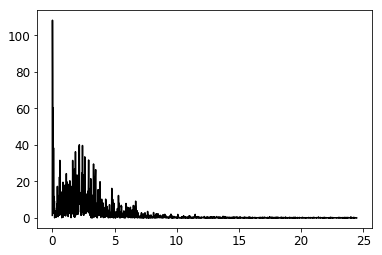

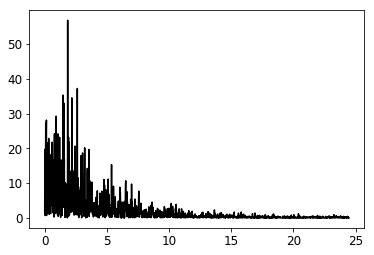

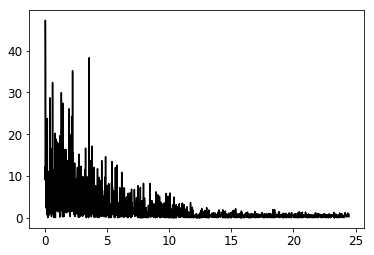

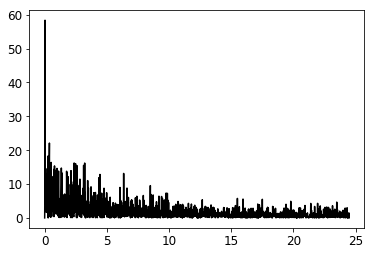

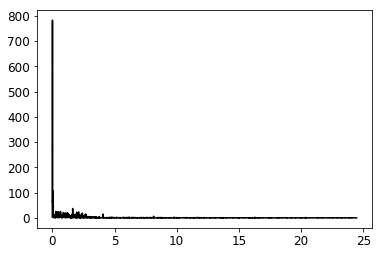

In [84]:
for i in range(5):
  plt.plot(frequency, pspec_df3.values[:,i], c='k')
  plt.show()

In [85]:
z = pspec_df3.values
z = scale(z, axis=0)

In [86]:
pca3 = PCA()

pca3.fit(z)

Z = pca3.transform(z)

pca3_df = pd.DataFrame(data = Z)
print(pca3_df.shape)
pca3_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.449122,5.788909,-0.889998,0.524105,-0.151334,0.451134,1.189473,0.598696,0.382486,-0.120534,...,3.230988e-05,1.292267e-05,2.410369e-05,3.193223e-05,-6.186597e-05,-2.956759e-05,-3.960944e-05,2.254321e-05,-8.964446e-05,1.651895e-05
1,211.074408,301.293037,-14.387217,38.490728,33.536036,-9.125735,-13.945090,-1.868113,-0.590823,1.134153,...,1.488688e-07,-5.061168e-08,-3.798172e-08,-1.037609e-07,-1.162980e-07,-4.311920e-09,1.164109e-07,-1.388524e-07,9.933111e-08,-2.531267e-09
2,379.913579,-18.587999,235.307035,-75.764303,-35.564079,-6.900063,-6.807254,1.320328,-2.779320,-2.360992,...,6.204294e-07,2.663077e-07,1.567579e-07,-4.022383e-07,1.510156e-07,7.286568e-07,-4.967646e-08,-2.907743e-07,-1.753758e-07,2.159020e-07
3,274.000292,-59.633491,-18.332571,207.950356,-103.249304,0.868784,-17.225141,2.444742,-3.989184,1.233389,...,-2.757512e-07,-4.265356e-08,-3.979760e-09,-2.491776e-08,-3.325269e-08,2.072679e-07,-5.307133e-08,1.330713e-07,-1.226028e-07,-1.769908e-07
4,240.495302,-71.378139,-3.063413,46.865656,166.167780,111.322320,-13.033015,-13.160364,-0.675365,6.108637,...,-1.369664e-07,-1.220435e-08,-3.924248e-07,-4.371233e-08,3.558364e-09,4.722114e-08,4.328809e-07,5.600085e-08,-1.256442e-07,5.718572e-08


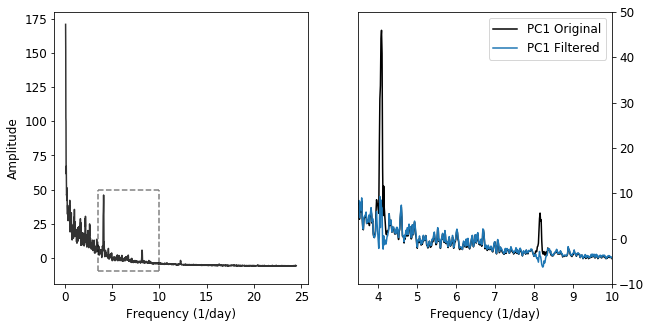

In [87]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(frequency[5:],pca_df[0][5:], c='k', alpha=0.8)
axes[0].set_ylabel('Amplitude')
axes[0].vlines(3.5,-10,50, color='grey', linestyle='--')
axes[0].vlines(10,-10,50, color='grey', linestyle='--')
axes[0].hlines(50,3.5,10, color='grey', linestyle='--')
axes[0].hlines(-10,3.5,10, color='grey', linestyle='--')
axes[0].set_xlabel('Frequency (1/day)')
#ax2.set_xticks([])
#ax2.set_xticklabels([])

axes[1].plot(frequency[5:], pca_df[0][5:], c='k',label='PC1 Original')
axes[1].plot(frequency[5:], pca3_df[0][5:], label='PC1 Filtered')
axes[1].set_xlim(3.5,10)
axes[1].set_ylim(-10,50)
#axes[1].set_xticks([])
#axes[1].set_xticklabels([])
axes[1].yaxis.tick_right()
axes[1].set_xlabel('Frequency (1/day)')
axes[1].legend()

plt.savefig('Figures/pc1_post.png',dpi=300, bbox_inches='tight')

# Investigating TOIs

## Check periodicity

In [ ]:
!pip install PyAstronomy

In [ ]:
from PyAstronomy.pyasl import foldAt

period = 0.2185
dur = np.nanmax(time1) - np.nanmin(time1)

# Obtain the phases with respect to some
# reference point 
phases = foldAt(time1[1:], period, T0=np.nanmin(time1))

# Sort with respect to phase
# First, get the order of indices ...
sortIndi = np.argsort(phases)
# ... and, second, rearrange the arrays.
phases = phases[sortIndi]
# Plot the result


plt.plot(phases-0.5, flux1norm[sortIndi], 'k.')
plt.plot(phases+0.5, flux1norm[sortIndi], 'k.')
#plt.plot(p-0.5, quadfit, c='cyan')
#plt.plot(p+0.5, quadfit, c='cyan')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (Raw)')
#plt.xlim(-0.5,1.5)
#plt.ylim(-0.1,0.1)
#plt.savefig('phasefold1.png',dpi=100,bbox_inches='tight')
plt.show()

plt.plot(phases-0.5, Filtered_signal1[sortIndi], 'k.')
plt.plot(phases+0.5, Filtered_signal1[sortIndi], 'k.')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (PCA-Filtered)')
#plt.xlim(-0.5,1.5)
#plt.ylim(-0.1,0.1)
#plt.savefig('phasefold2.png',dpi=100,bbox_inches='tight')
plt.show()

## Model flares

In [ ]:
flares = [2253.65107,
          2240.04075,
          2281.57290,
          2284.68258,
          2287.91009,
          2268.87127,
          2295.39965,
          2299.37770,
          2291.45770,
          2248.59421,
          2261.51045,
          2269.02792,
          2249.17243,
          2276.02709,
          2229.08574,
          2293.30131,
          2295.02575,
          2258.54786,
          2284.92844,
          2238.85706,
          2251.42265,
          2249.41148,
         ]

In [ ]:
len(flares)

In [ ]:
fig, axes = plt.subplots(22, figsize=(10,60))

for i,flare in enumerate(flares):
  axes[i].scatter(time1, Filtered_signal1, color='k', marker='.', s=5)
  axes[i].vlines(flare, -50, 50, color='k', ls='--', alpha=0.25, label=str(flare))
  #axes[i].vlines(flare+(1./72), -50, 50, color='k', ls='--', alpha=0.75)
  #axes[i].vlines(flare-(1./96), -50, 50, color='k', ls='--', alpha=0.75)
  axes[i].set_xlim(flare-0.1,flare+0.1)
  axes[i].set_ylim(0.9,1.5)
  axes[i].set_ylabel('Rel. Flux')
  axes[i].legend()
plt.xlabel('BJD', fontsize=12)
plt.savefig('Figures/flares.png', bbox_inches='tight')
plt.show()

## Gabor Filtering

In [ ]:
def gabor1D(x, Lambda, sigma=1, nstds=3, offset=0):

  gb = np.exp(-.5 * (x ** 2 / sigma ** 2)) * np.cos(2 * np.pi / Lambda * x + offset)

  return gb

In [ ]:
i=1
x = np.arange(-50,50)
while i <= 32:
  print('Lambda = {}'.format(i))
  plt.plot(gabor1D(x, Lambda=i, sigma=8, nstds=10))
  plt.show()
  i *= 2

In [ ]:
plt.plot(gabor1D(x, 2, sigma=5, nstds=5))
plt.savefig('Figures/gabor.png', dpi=100)

In [ ]:
plt.plot(time2[1:], Filtered_signal2)

In [ ]:
peakind = np.where(Filtered_signal2==Filtered_signal2.max())[0][0]

In [ ]:
plt.plot(time2[1:][peakind-50:peakind+50], Filtered_signal2[peakind-50:peakind+50])

In [ ]:
@interact
def gfiltergame(l=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=2),
                s=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=5),
                a=widgets.FloatSlider(min=1, max=50, step=1, value=30),
                offset1 = widgets.IntSlider(min=0, max=10, step=1, value=0),
                offset2 = widgets.IntSlider(min=0, max=10, step=1, value=1)):
  
  n=10
  y = Filtered_signal2[peakind-50:peakind+50]
  x = np.arange(-len(y)/2,len(y)/2)

  gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)

  gabor = np.concatenate((gabor1[offset1:int(len(y)/2)], np.zeros(offset1), np.zeros(offset2), gabor2[int(len(y)/2):len(y)-offset2]))

  '''
  plt.plot(x, gabor1[offset1:int(len(y)/2)], label='Gabor1')
  plt.plot(x, gabor2[int(len(y)/2):-offset2], label='Gabor2')
  plt.plot(x, y, alpha=0.5, label='Ringing')
  plt.vlines(0,-200,200, alpha=0.5, ls='--')
  plt.legend()
  plt.show()
  '''
  plt.plot(x,y, label='Data')
  plt.legend()
  plt.show()

  plt.plot(x,y - gabor, color='r', label='Result')
  plt.vlines(0,-200,200, alpha=0.5, ls='--')
  plt.ylim(-50,300)
  plt.legend();

In [ ]:
a = 30
s = 5
l = 2
offset1_true = 0 
offset2_true = 1 
n=10

y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

def gmodel(x,a,s,l):

  n=10

  gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor = np.concatenate((gabor1[offset1_true:int(len(y)/2)], np.zeros(offset1_true), 
                          np.zeros(offset2_true), gabor2[int(len(y)/2):len(y)-offset2_true]))

  return gabor



In [12]:
yred = y - gmodel(x,a,s,l)
np.where(yred == yred.max())[0][0]

NameError: name 'y' is not defined

In [13]:
flrmask = np.ones_like(yred, dtype='bool')
mask_l = 48
mask_r = 52
flrmask[mask_l:mask_r] = False

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(yred)
ax[1].plot(yred[~flrmask])
ax[2].plot(yred[flrmask])

ax[0].set_ylim(-50,300)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,300)
ax[2].set_ylim(-50,300);

NameError: name 'yred' is not defined

## Gabor Optimization

In [14]:
!pip install emcee

You should consider upgrading via the '/Users/Riley/anaconda/bin/python -m pip install --upgrade pip' command.


In [15]:
!pip install corner

You should consider upgrading via the '/Users/Riley/anaconda/bin/python -m pip install --upgrade pip' command.


In [16]:
import emcee
from scipy.optimize import minimize

In [17]:
offset_fctr = 1e-4

a_true = 30
s_true = 5
l_true = 2
m_true = np.mean(y[:30])
offset1_true = 0 * offset_fctr
offset2_true = 1 * offset_fctr

n=10

def gmodel(x,a,s,l,offset1,offset2):

  n=10
  #print(int(offset1 / offset_fctr), int(offset2 / offset_fctr))
  gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor = np.concatenate((gabor1[int(offset1 / offset_fctr):int(len(y)/2)], 
                          np.zeros(int(offset1 / offset_fctr)), 
                          np.zeros(int(offset2 / offset_fctr)), 
                          gabor2[int(len(y)/2):len(y)-int(offset2 / offset_fctr)]))
  return gabor

y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

def log_likelihood(theta, x, y):
    if len(theta) == 4:
      a,s,l,m = theta
      offset1 = offset1_true
      offset2 = offset2_true
    if len(theta) == 6:
      a, s, l, m, offset1, offset2 = theta

    model = gmodel(x,a,s,l,offset1,offset2)
    yred = y - model
    pred = np.zeros_like(yred)[flrmask] + m # put NaNs in here @ flare
    return -0.5 * np.nansum((yred[flrmask] - pred) ** 2)

NameError: name 'y' is not defined

In [ ]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([a_true, s_true, l_true, m_true]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(x, y))
a_ml, s_ml, l_ml, m_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("s = {0:.3f}".format(s_ml))
print("l = {0:.3f}".format(l_ml))
print("m = {0:.3f}".format(m_ml))

In [ ]:
def log_prior(theta):
    a, s, l, m, offset1, offset2 = theta
    if 0.0 < a < 50.0 and 0.0 < s < 10.0 and 0.0 < l < 20.0 and 0.0 < m < 5.0 \
    and int(0) < offset1 < (10 * offset_fctr) and int(0) < offset2 < (10 * offset_fctr):
        return 0.0
    return -np.inf

In [ ]:
def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

In [ ]:
soln6 = np.append(soln.x, [offset1_true, offset2_true])

In [ ]:
###MCMC
pos = soln6 + 1e-3 * np.random.randn(128, 6)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 5000, progress=True);

In [ ]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "s", "l", "m", "offset1", "offset2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
flat_samples[:,4:] /= offset_fctr

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[a_ml, s_ml, l_ml, m_ml, offset1_true / offset_fctr, offset2_true / offset_fctr]
)

axes = np.array(fig.axes).reshape((6, 6))

for ax in fig.get_axes():
  ax.xaxis.label.set_size(24)
  ax.yaxis.label.set_size(24)

plt.savefig('Figures/gabor_corner.png', dpi=100, bbox_inches='tight')

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    if "offset" in labels[i]:
      txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    else:
      txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
a_fit = np.percentile(flat_samples[:, 0], 50)
s_fit = np.percentile(flat_samples[:, 1], 50)
l_fit = np.percentile(flat_samples[:, 2], 50)
m_fit = np.percentile(flat_samples[:, 3], 50)
off1_fit = np.percentile(flat_samples[:, 4], 50)
off2_fit = np.percentile(flat_samples[:, 5], 50)

y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, yred)
ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, offset1_true, offset2_true))
ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr))

ax[0].vlines(mask_l-50,-300,300, color='k', ls='--', alpha=0.5)
ax[0].vlines(mask_r-50,-300,300, color='k', ls='--', alpha=0.5)

ax[1].vlines(mask_l-50,-300,300, color='k', ls='--', alpha=0.5)
ax[1].vlines(mask_r-50,-300,300, color='k', ls='--', alpha=0.5)

ax[0].set_ylim(-100,300)
ax[1].set_ylim(-100,300)

ax[0].set_title('By Eye')
ax[1].set_title('MCMC');

In [ ]:
y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y, color='k')
ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr), color='k')

flrtime = 2454833 - time2[peakind]

ax[0].set_title('Ringing')
ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[0].set_ylabel('Standardized Flux')
ax[0].set_ylim(-75,300)


ax[1].set_title('Gabor-Filtered Ringing')
ax[1].set_yticks([])
ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[1].set_ylim(-75,300)

plt.savefig('Figures/mcmc_comp.png', dpi=100, bbox_inches='tight')